# Laboratório 11: Colheita de madeira

### Referente ao capítulo 18

Considere uma fazenda de madeiras que possui uma regulamentação em que, após uma extração fixa de porcentagem da população de árvores, deve replantar. Assumimos que a fazenda opera com porcentagem constante de extração, produzindo $x(t)$. Crescimento e mortes naturais de árvores não são consideradas. A quantidade de madeira é baseada apenas no tamanho da fazenda. Consideramos também que o nível de extração é baixo o suficiente para que a idade  da árvore não seja considerada e portanto sempre será madura. Após o processamento da madeira, ela é imediatamente vendida. 

O dinheiro ganho pode ser tido como lucro ou reinvestido na fazenda. Os donos da fazenda querem uma estratégia de reinvestimento que maximiza o lucro em um período fixo de tempo. Seja $u(t)$ a porcentafem da madeira vendida que é reinvestida. 

Assim $x'(t) = kx(t)u(t)$, onde $k$ é constante de retorno, que leva em conta o custo médio de trabalho e terra. Se $p$ é o preço de mercado por unidade de madeira, então o lucro total é dado por 

$$
p\int_0^T x(t)[1 - u(t)]dt 
$$

Como estamos lidando com tempo que pode ser considerado suficientemente longo, vamos adicionar um tempo $e^{-rt}$ para trazer a *valor presente* o valor investido no tempo $t$. Isso considera que o lucro investido mais cedo pode ser investido e ganhar uma taxa de juros $r$. Assim o funcional objetivo se torna 

$$
p\int_0^T e^{-rt}x(t)[1 - u(t)]dt 
$$

Porém a constante $p$ não deve afetar o problema e é, portanto, desconsiderado. Além disso, seja $x(0) = x_0> 0 $ e $0 \le u(t) \le 1$. 

### Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp

import sys  
sys.path.insert(0, '../pyscripts/')

from optimal_control_class import OptimalControl

## Condições necessárias 

Mais uma vez vamos utilizar a biblioteca simbólica para nos ajudar nos cálculos. Note que esse sistema é tão simples que de fato não seria muito necessário, mas vamos usar assim mesmo. 

### Hamiltoniano

In [4]:
x, u, l, t, r, k = sp.symbols('x u lambda t r k')
H = sp.exp(-r*t)*x*(1 - u) + k*x*u*l
H

k*lambda*u*x + x*(1 - u)*exp(-r*t)

### Condições do Estado

In [5]:
print(sp.diff(H,l))

k*u*x


### Equaçãoes Adjuntas

In [6]:
dl = (-1)*sp.diff(H,x)
print(dl)

-k*lambda*u - (1 - u)*exp(-r*t)


### Transversalidade 

$\lambda(T) = 0$

### Otimalidade

In [7]:
psi = sp.diff(H,u)
psi

k*lambda*x - x*exp(-r*t)

## Demonstração que o problema é Bang-Bang

Vemos que $x'(t) \ge 0 \implies x(t) > 0, \forall t \in [0,T]$. Suponha que $\psi = 0$ em algum intervalo. Então 
$\lambda(t) = \frac{1}{k}e^{-rt}$ nesse intervalo. Portanto 
$\lambda'(t) = -\frac{r}{k}e^{-rt} = -e^{-rt}u - (1 - u)e^{-rt} = -e ^{-rt}$. Se $k \neq r$, isso é uma contradição. ]

Se $k=r$, verifiquemos como $\lambda(t)$ é em um intervalo contendo $t = T$: 

- Se $u^* = 1 \implies \lambda '(t) = -k\lambda \implies \lambda(t) \equiv 0$. 
- Se $u^* = 0 \implies \lambda '(t) = - e^{-rt} \implies \lambda(t) = \frac{1}{k}e^{-rt}$, o que não é possível. Então $u^* = 1$.  

Mas não é possível que essas funções formem uma única função contínua, o que é uma contradição. Assim o problema é Bang-Bang. 

## Aplicando a classe ao exemplo 

Vamos começar as experimentações

In [8]:
parameters = {'k': None, 'r': None}

diff_state = lambda t, x, u, par: par['k']*x*u

diff_lambda = lambda t, x, u, lambda_, par: -par['k']*lambda_*u - (1 - u)*np.exp(-par['r']*t)

update_u = lambda t, x, lambda_, par: 0.0 if par['k']*lambda_ < np.exp(- par['r']*t) else 1.0 

In [9]:
problem = OptimalControl(diff_state, diff_lambda, update_u, 
                         n_controls = 1, n_states = 1, 
                         bounds = [(0,1)])

In [10]:
x0 = 100
T = 5
parameters['k'] = 1
parameters['r'] = 0

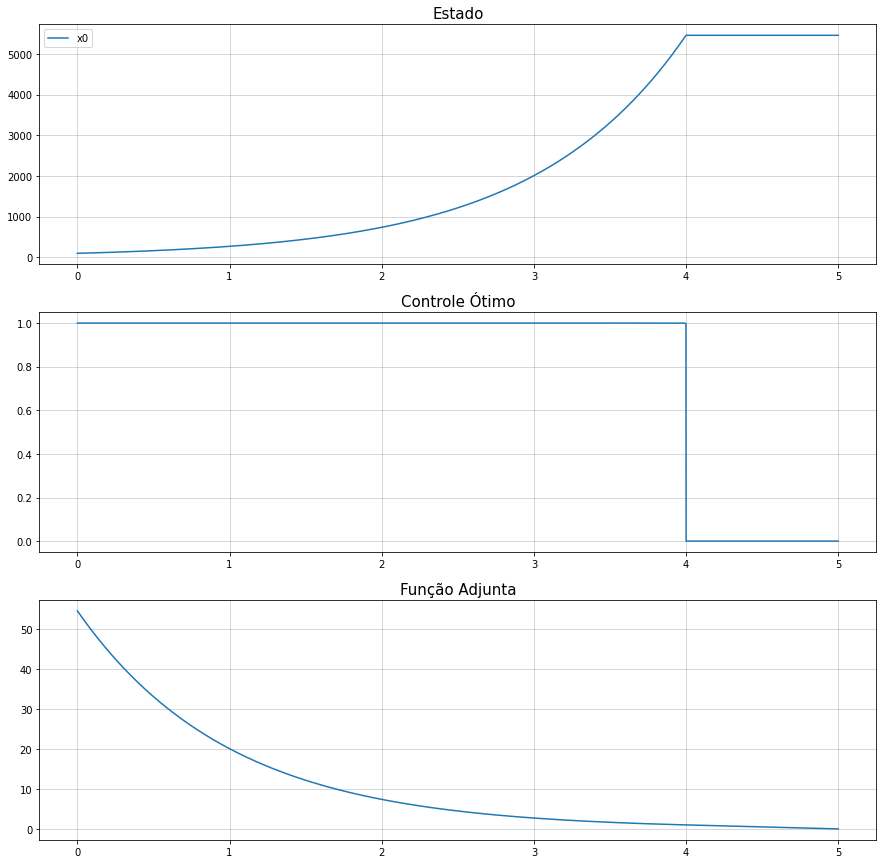

In [11]:
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)
ax[0].legend()
plt.show()

Observe que existe uma mudança abrupta no controle em $t = 4$, como esperávamos de um problema Bang Bang. Entretanto, essa reta ligando os pontos não existe propriamente, é apenas uma ilusão criado pelo gráfico que liga os pontos para parecer uma função contínua. No caso sabemos que não é. Esse é o pornto de troca. Essa estratégia nos diz para os fazendeiros reinvestirem tudo n o início e depois, manter para lucro. Mas veja que $r = 0$, então isso faz sentido. 

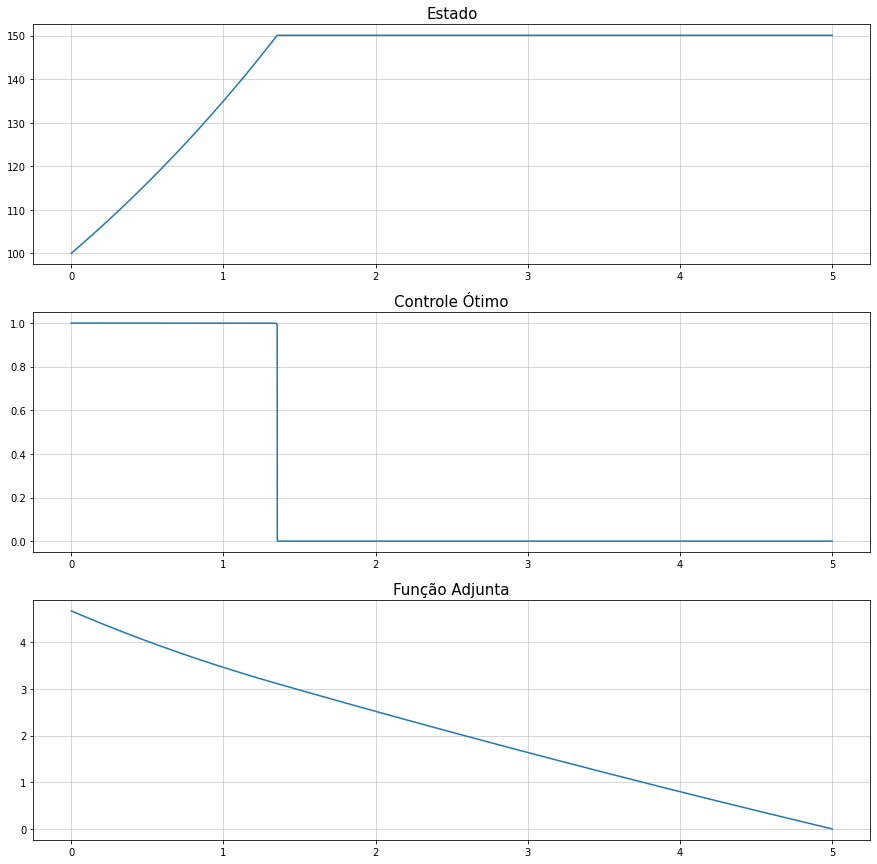

In [12]:
parameters['k'] = 0.3
parameters['r'] = 0.05
t,x,u,lambda_ = problem.solve(x0, T, parameters)
ax = problem.plotting(t,x,u,lambda_)

Com taxa de juros, fica mais interessante começar a manter o lucro um pouco antes, afim de ganhar com o juros. Vamos verificar como valor de $k$ representa no controle escolhido. Em geral não temos controle sobre o valor de $k$ mas já sabemos que quanto maior, mais o reinvestimento aumenta a área plantada. 

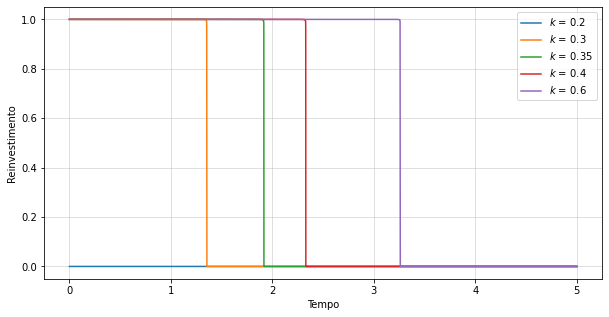

In [16]:
k_values = [0.2, 0.3, 0.35, 0.4, 0.6]
u_values = []
for k in k_values: 
    parameters['k'] = k
    _,_,u,_ = problem.solve(x0, T, parameters)
    u_values.append(u)
    
fig = plt.figure(figsize = (10,5))
plt.xlabel("Tempo")
plt.ylabel("Reinvestimento")
for i, k in enumerate(k_values):
    plt.plot(t, u_values[i],label = r'$k$ = {}'.format(k))
plt.legend()
plt.grid(alpha = 0.5)

Observe que quanto maior o efeito do reinvestimento, mais tardio vai ser nossa troca de estratégia, porque vale a pena reinvestir se isso está nos garantindo maiores lucros no futuro. No caso em que $k = 0.2$ nem vale a pena reinvestir de tão baixo que o reinvestimento é considerado. 

Podemos analisar o efeito da taxa de juros também. Quanto maior a taxa de juros, melhor deixar o dinheiro rendendo sozinho do que reinvestir na fazenda. No caso em que $r = 0.2$, é melhor nem mexer na fazenda, só investir tudo que se ganha. 

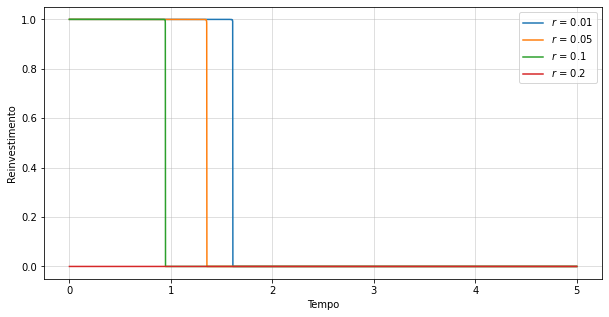

In [18]:
parameters['k'] = 0.3
r_values = [0.01, 0.05, 0.1, 0.2]
u_values = []
for r in r_values: 
    parameters['r'] = r
    _,_,u,_ = problem.solve(x0, T, parameters)
    u_values.append(u)
    
fig = plt.figure(figsize = (10,5))
plt.xlabel("Tempo")
plt.ylabel("Reinvestimento")
for i, r in enumerate(r_values):
    plt.plot(t, u_values[i],label = r'$r$ = {}'.format(r))
plt.legend()
plt.grid(alpha = 0.5)

Por fim, vamos discutir algumas particularidades desse problema. Vamos calcular $r=0, k = T = 1$. 

Você deve ter visto que se passaram mais de 10 minutos. Isso ocorre, pois o problema não converge devido ao *round-off error*. Quando o valor do controle ótimo é $u = 0$, temos que $\lambda '(t) = -1$. Assim $\lambda(t) = 1 - t$. Entretanto, o valor calculado numericamente de $\lambda(0)$ é aproximadamente $1 + 10^{-16}$. Isso é, a princípio, insignificante, mas no leva a ter 
$$
H_u(0) > 0
$$
o que nos direciona a calcular $u(0) = 1$ quando esperávamos que ele fosse $0$. Com o tempo, pela média que calculamos do valor anterior com o atual, esse valor vai se reduzindo para $0.5, 0.25, 0.125$, o que no limite é zero, mas nossa regra de atualização fará com que o problema não convirja. Assim, o erro é dado pela forma que o número é guardado no computador e o método que desenvolvemos não é capaz de lidar com isso. 

Por esse motivo, ao invés de forçar uma representação para $u^*$, muitas vezes os algoritmos que resolvem problemas Bang Bang procuram estimar os tempos de troca. 